In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import weighted

# TASK 1


In [150]:
def gen_data(n=5000):
    X=np.random.uniform(0,np.pi,(n,10))
    cond=np.sum(np.sin(X[:,0:4]),axis=1)
    y=np.where(cond>=2.5,1,0)
    return X,y

In [151]:
X,y=gen_data()

In [152]:
np.unique(y,return_counts=True)

(array([0, 1]), array([2307, 2693]))

# Task 2

In [153]:
from sklearn.tree import DecisionTreeClassifier

In [154]:
class RandomSubspaceClassifier:
    def __init__(self,B=100,m=5):
        self.B=B
        self.m=m
        self.classifiers=[]
        self.subspaces=[]
    def fit(self,X,y):
        n_features=X.shape[1]
        for b in range(self.B):
            feats=np.random.choice(n_features,self.m)
            X_new=X[:,feats]
            model=DecisionTreeClassifier(max_depth=3)
            model.fit(X_new,y)
            self.classifiers.append(model)
            self.subspaces.append(feats)
        return self
    
    def predict(self,X):
        n_samples=X.shape[0]
        y_pred=np.zeros(n_samples)
        for (cls,sub) in zip(self.classifiers,self.subspaces):
            y_pred+=cls.predict(X[:,sub])
        y=np.where(y_pred>=self.B/2,1,0)
        return y

In [155]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [156]:
model=RandomSubspaceClassifier().fit(X_train,y_train)

In [157]:
from sklearn.metrics import accuracy_score

In [158]:
def plot(X_train,X_test,y_train,y_test):
    accs=[]
    n=X_train.shape[1]
    ms=[]
    for m in range(1,n+1):
        model=RandomSubspaceClassifier(m=m)
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        accs.append(accuracy_score(y_test,y_pred))
        ms.append(m)
        
    plt.figure(figsize=(10,8))
    plt.title("accuracy of RSM vs subspace size")
    plt.xlabel("subspace size")
    plt.ylabel("accuracy")
    plt.plot(ms,accs)
    plt.grid(True)
    plt.show()
        

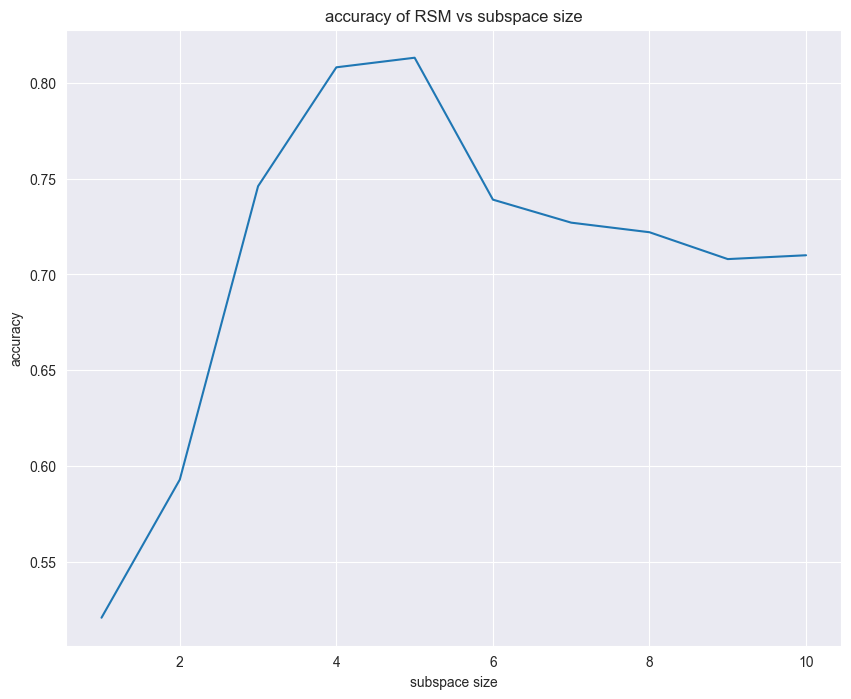

In [159]:
plot(X_train,X_test,y_train,y_test)

# Task 3

In [65]:
from scipy import stats

In [70]:
def true_f(x):
    return .7*stats.norm.pdf(x,loc=3,scale=1)+.3*stats.norm.pdf(x,loc=6,scale=1)

In [76]:
def gen_data_2(n=1000):
    x=np.random.uniform(0,10,n)
    eps=np.random.normal(0,0.05,n)
    y=true_f(x)+eps
    return x,y

In [162]:
x,y=gen_data_2()

In [163]:
class GaussianKernel:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
    def eval(self, x, x0):
        return np.exp(-np.square(x-x0) / (2 * np.square(self.bandwidth))) / (np.sqrt(2 * np.pi) * self.bandwidth)

In [164]:
from sklearn.linear_model import LinearRegression

In [165]:
class KernelQuadraticRegression:
    def __init__(self,h):
        self.kernel=GaussianKernel(h)
    def fit(self,X,y):
        self.X=X
        self.y=y
        return self
    def predict(self,x):
        y_pred=np.zeros_like(x)
        X=np.column_stack((self.X,self.X**2))
        for i,x0 in enumerate(x):
            weights=self.kernel.eval(X[:,0],x0)
            model=LinearRegression().fit(X,self.y,weights)
            y_pred[i]=model.intercept_+model.coef_[0]*x0+model.coef_[1]*x0*x0
        return y_pred

In [166]:
x_lin=np.linspace(0,10,1000)

In [167]:
reg=KernelQuadraticRegression(1).fit(x,y)

In [168]:
y_pred=reg.predict(x_lin)

In [169]:
def create_plots(x,y):
    plt.figure(figsize=(10,8))
    plt.scatter(x,y,label="scatter of sample",color="black",alpha=0.5)
    plt.title("comparison of Kernel quadratic regession for different smoothing parameters")
    x_lin=np.linspace(0,10,1000)
    plt.plot(x_lin,true_f(x_lin),label="true function")
    
    H=[1,0.5,0.05]
    for h in H:
        model=KernelQuadraticRegression(h).fit(x,y)
        y_pred=model.predict(x_lin)
        plt.plot(x_lin,y_pred,label=f"estiamtion of function for smoothing parameter = {h}")
    plt.legend()
    plt.show()

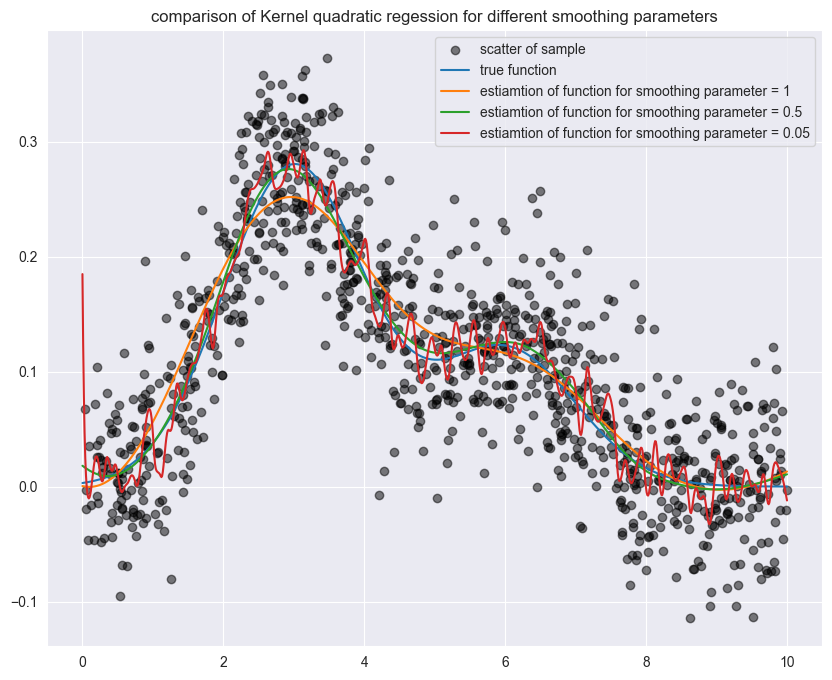

In [170]:
create_plots(x,y)